In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Attention, LayerNormalization, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [13]:
days = 365
baseline_hrv = 55 + np.sin(np.linspace(0, 3*np.pi, days)) * 8
stress_cycles = np.sin(np.linspace(0, 16*np.pi, days)) * 12

df = pd.DataFrame({
    "HRV": baseline_hrv + np.random.normal(0, 4, days),
    "HR": 75 - (baseline_hrv - 55) * 0.8 + np.random.normal(0, 3, days),
    "BreathingRate": 14 + (stress_cycles / 10) + np.random.normal(0, 1.2, days),
    "EDA": 0.55 + (stress_cycles / 50) + np.random.normal(0, 0.05, days),
    "SkinTemp": 36.6 + np.random.normal(0, 0.2, days),
    "Steps": 7000 - (stress_cycles * 120) + np.random.normal(0, 800, days),
    "ActiveMinutes": 55 - (stress_cycles * 2.2) + np.random.normal(0, 6, days),
    "SleepHours": 7.2 - (stress_cycles / 20) + np.random.normal(0, 0.4, days),
    "SleepInterruptions": (stress_cycles > 8).astype(int) + np.random.poisson(1, days)
})

df["StressScore"] = (
    (100 - df["HRV"]) * 0.22 +
    (df["HR"] - 55) * 0.18 +
    (df["BreathingRate"] - 12) * 1.3 +
    (df["EDA"] * 20) +
    (8 - df["SleepHours"]) * 2.2 +
    df["SleepInterruptions"] * 4
).clip(0, 100)

In [26]:
df.to_csv("stress_dataset.csv", index=False)

In [14]:
SEQ_LEN = 7
X_raw = df.drop(columns=["StressScore"]).values
y_raw = df["StressScore"].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

X, y = [], []
for i in range(len(X_scaled) - SEQ_LEN):
    X.append(X_scaled[i:i + SEQ_LEN])
    y.append(y_raw[i + SEQ_LEN])

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [20]:
inp = Input(shape=(SEQ_LEN, X.shape[2]))

x = Bidirectional(LSTM(64, return_sequences=True))(inp)
att = Attention()([x, x])
x = LayerNormalization()(att)

x = Conv1D(32, 2, activation="relu")(x)
x = GlobalMaxPooling1D()(x)

x = Dense(64, activation="relu")(x)     # ← fixed (call the layer here)
x = Dropout(0.25)(x)

out = Dense(1)(x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="mse",
    metrics=["mae"]
)



In [21]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=55, batch_size=16, verbose=1)

Epoch 1/55
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 32.3888 - mae: 4.4537 - val_loss: 22.9574 - val_mae: 3.7626
Epoch 2/55
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 28.9061 - mae: 4.4154 - val_loss: 25.2258 - val_mae: 3.9687
Epoch 3/55
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 32.5032 - mae: 4.6732 - val_loss: 24.2278 - val_mae: 3.8810
Epoch 4/55
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 33.6295 - mae: 4.7667 - val_loss: 23.5946 - val_mae: 3.8176
Epoch 5/55
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 27.6075 - mae: 4.1111 - val_loss: 25.7342 - val_mae: 4.0196
Epoch 6/55
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 29.1062 - mae: 4.2464 - val_loss: 25.4752 - val_mae: 4.0105
Epoch 7/55
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 34.0078 - mae: 4.4516 - val_loss: 23.7142 - val_mae: 3.8468
Epoch 8/55
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 32.0213 - mae: 4.4179 - val_loss: 26.6475 - val_mae: 4.0923
Epoch 9/55
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/st

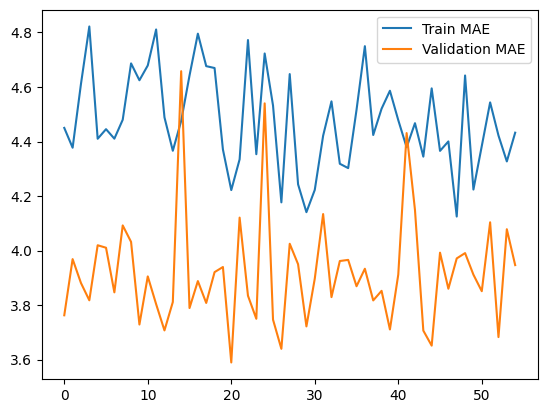

In [22]:
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model.predict(X_test).flatten()

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
MAE: 3.946677300754762
RMSE: 5.035543832888664
R²: 0.4926973103369049


In [7]:
model.save("neurocare_stress_model.h5")
import pickle
pickle.dump(scaler, open("neurocare_scaler.pkl", "wb"))


In [24]:
OPENROUTER_API_KEY = "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"

def generate_explanation(stress_score, last_day_row):
    payload = {
        "model": "google/gemma-3-27b-it:free",
        "messages": [
            {"role": "system", "content": "You are an empathetic wellness assistant."},
            {
                "role": "user",
                "content": f"""
Stress score: {stress_score}
Recent vitals: {dict(last_day_row)}

Explain in 3–5 sentences what the user might be feeling emotionally and physically,
and offer comforting guidance. Avoid medical warnings.
"""
            }
        ]
    }

    resp = requests.post(
        "https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps(payload)
    )
    return resp.json()["choices"][0]["message"]["content"]


In [25]:
latest_5 = df.drop(columns=["StressScore"]).tail(5)
pred = predict_stress_score(latest_5)
text = generate_explanation(pred, latest_5.tail(1).iloc[0])

print(f"Stress Score: {round(pred,2)}/100")
print("\nEmotional Interpretation:\n", text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Stress Score: 33.37/100

Emotional Interpretation:
 
Okay, looking at your numbers, it seems like you're holding a moderate amount of stress – a score of 33.37 suggests you're likely feeling a bit tense or overwhelmed, perhaps with a sense of being "on edge." Physically, your body is showing some signs of that stress with a slightly elevated heart rate and EDA (which reflects your body's response to stress and excitement). However, it's *really* positive to see you got a good 7 hours of sleep and are quite active – those are fantastic foundations for well-being! 

It's completely okay to feel this way sometimes. Perhaps taking a few moments for gentle breathing, listening to calming music, or simply doing something you enjoy could help ease that tension. Remember to be kind to yourself and acknowledge that you're doing a lot right – prioritizing sleep and movement is a wonderful start.




